In [1]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import tqdm
import matplotlib.pyplot as pp
import numpy as np

In [2]:
transitions = {
    1: {0: 1, 1: 2, 2: 1, 3: 3, 4: 1},
    2: {0: 2, 1: 12, 2: 1, 3: 2, 4: 2},
    3: {0: 3, 1: 3, 2: 3, 3: 4, 4: 1},
    4: {0: 4, 1: 5, 2: 4, 3: 6, 4: 3},
    5: {0: 5, 1: 13, 2: 4, 3: 5, 4: 5},
    6: {0: 6, 1: 6, 2: 6, 3: 7, 4: 4},
    7: {0: 7, 1: 8, 2: 7, 3: 9, 4: 6},
    8: {0: 8, 1: 14, 2: 7, 3: 8, 4: 8},
    9: {0: 9, 1: 9, 2: 9, 3: 10, 4: 7},
    10: {0: 10, 1: 11, 2: 10, 3: 10, 4: 9},
    11: {0: 11, 1: 15, 2: 10, 3: 16, 4: 11},
    12: {0: 12, 1: 18, 2: 2, 3: 12, 4: 12},
    13: {0: 13, 1: 19, 2: 5, 3: 13, 4: 13},
    14: {0: 14, 1: 20, 2: 8, 3: 14, 4: 14},
    15: {0: 15, 1: 21, 2: 11, 3: 17, 4: 15},
    16: {0: 16, 1: 17, 2: 16, 3: 16, 4: 11},
    17: {0: 17, 1: 22, 2: 16, 3: 23, 4: 15},
    18: {0: 18, 1: 18, 2: 12, 3: 25, 4: 18},
    19: {0: 19, 1: 19, 2: 13, 3: 26, 4: 25},
    20: {0: 20, 1: 20, 2: 14, 3: 27, 4: 26},
    21: {0: 21, 1: 21, 2: 15, 3: 22, 4: 27},
    22: {0: 22, 1: 22, 2: 17, 3: 24, 4: 21},
    23: {0: 23, 1: 24, 2: 17, 3: 23, 4: 17},
    24: {0: 24, 1: 22, 2: 23, 3: 24, 4: 22},
    25: {0: 25, 1: 25, 2: 25, 3: 19, 4: 18},
    26: {0: 26, 1: 26, 2: 26, 3: 20, 4: 19},
    27: {0: 27, 1: 27, 2: 27, 3: 21, 4: 20}
}

def state_to_vec(state):
    result = [0]*27
    result[state-1] = 1
    return torch.tensor(result).float()

def compute_reward(state):
    if state == 11:
        return torch.tensor(100)
    return torch.tensor(0)

INPUT_DIMS = 27
OUTPUT_DIMS = 5
NUM_EPOCHS = 100000
TRAJECTORY_LENGTH = 20
BATCH_SIZE = 100
START_NODE = 6
LEARNING_RATE = 3e-4

In [3]:
class TBModel(nn.Module):
  def __init__(self, num_hid):
    super().__init__()

    self.mlp_forward = nn.Sequential(nn.Linear(INPUT_DIMS, num_hid), nn.LeakyReLU(),
                             nn.Linear(num_hid, OUTPUT_DIMS))
    
    self.mlp_backward = nn.Sequential(nn.Linear(INPUT_DIMS, num_hid), nn.LeakyReLU(),
                             nn.Linear(num_hid, OUTPUT_DIMS))
    
    self.logZ = nn.Parameter(torch.ones(1))

  def forward(self, x):
    P_F = self.mlp_forward(x)
    return P_F
  
  def backward(self, x):
    P_B = self.mlp_backward(x) 

    return P_B

In [4]:
# Very basic toy env 

model = TBModel(512)
opt = torch.optim.Adam(model.parameters(),  3e-4)

tb_losses = []
tb_rewards = []
logZs = []

minibatch_loss = 0
minibatch_reward = 0

for episode in tqdm.tqdm(range(NUM_EPOCHS), ncols=40):
  state = START_NODE
  
  total_P_F = 0
  total_P_B = 0
  reward = torch.tensor(0)
  for t in range(TRAJECTORY_LENGTH):
    P_F_s = model.forward(state_to_vec(state))
    P_B_s = model.backward(state_to_vec(state))
    reward = reward + compute_reward(state)

    cat = Categorical(logits=P_F_s)
    action = cat.sample()
    new_state = transitions[state][action.item()]
    total_P_F += cat.log_prob(action)

    total_P_B += Categorical(logits=P_B_s).log_prob(action)

    state = new_state

  print(f'reward {reward}')
  loss = (model.logZ + total_P_F - torch.log(reward).clip(-20) - total_P_B).pow(2)
  minibatch_loss += loss
  minibatch_reward += reward

  if (episode + 1) % BATCH_SIZE == 0:
    print(f'minibatch_loss {minibatch_loss}')
    tb_losses.append(minibatch_loss.item())
    tb_rewards.append(minibatch_reward.item())
    minibatch_loss.backward()
    opt.step()
    opt.zero_grad()
    minibatch_loss = 0
    minibatch_reward = 0
    logZs.append(model.logZ.item())

  0%| | 98/100000 [00:00<12:35, 132.20it

minibatch_loss tensor([40789.0977], grad_fn=<AddBackward0>)


  0%| | 187/100000 [00:02<16:30, 100.76i

minibatch_loss tensor([38918.5977], grad_fn=<AddBackward0>)


  0%| | 290/100000 [00:03<15:01, 110.57i

minibatch_loss tensor([42893.1055], grad_fn=<AddBackward0>)


  0%| | 393/100000 [00:04<13:16, 125.08i

minibatch_loss tensor([38708.5078], grad_fn=<AddBackward0>)


  0%| | 497/100000 [00:05<13:08, 126.18i

minibatch_loss tensor([38002.5859], grad_fn=<AddBackward0>)


  1%| | 597/100000 [00:06<13:36, 121.75i

minibatch_loss tensor([40525.1406], grad_fn=<AddBackward0>)


  1%| | 698/100000 [00:07<13:45, 120.29i

minibatch_loss tensor([37953.1289], grad_fn=<AddBackward0>)


  1%| | 787/100000 [00:08<13:47, 119.90i

minibatch_loss tensor([41314.8242], grad_fn=<AddBackward0>)


  1%| | 891/100000 [00:09<13:05, 126.11i

minibatch_loss tensor([34311.3438], grad_fn=<AddBackward0>)


  1%| | 899/100000 [00:10<18:48, 87.84it


KeyboardInterrupt: 

Text(0, 0.5, 'rewards')

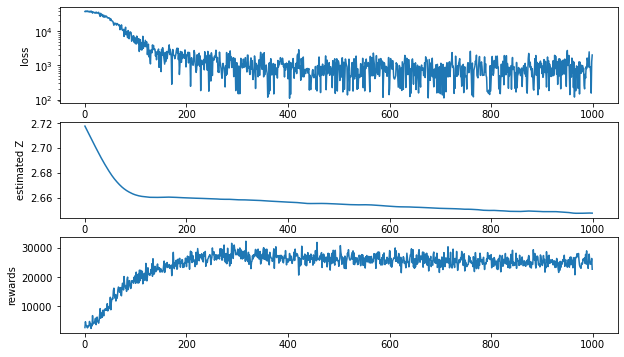

In [5]:
f, ax = pp.subplots(3, 1, figsize=(10,6))
pp.sca(ax[0])
pp.plot(tb_losses)
pp.yscale('log')
pp.ylabel('loss')
pp.sca(ax[1])
pp.plot(np.exp(logZs))
pp.ylabel('estimated Z')
pp.sca(ax[2])
pp.plot(tb_rewards)
pp.ylabel('rewards')

In [15]:
state = START_NODE

for t in range(TRAJECTORY_LENGTH):
    print(f'state {state}')
    P_F_s = model.forward(state_to_vec(state))
    P_B_s = model.backward(state_to_vec(state))

    cat = Categorical(logits=P_F_s)
    action = cat.sample()
    new_state = transitions[state][action.item()]
    total_P_F += cat.log_prob(action)

    total_P_B += Categorical(logits=P_B_s).log_prob(action)

    state = new_state

state 6
state 6
state 7
state 7
state 9
state 9
state 10
state 10
state 9
state 9
state 10
state 10
state 10
state 11
state 11
state 11
state 10
state 11
state 15
state 17
